<a href="https://colab.research.google.com/github/keelinarseneault/ML-Engineering/blob/main/Vision_Transformer_(Capstone_Step_8).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **ViT (Vision Transformer)**

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision.transforms.v2 import GaussianNoise
import torchvision.models as models
from torch.utils.data import DataLoader, Dataset, random_split, Subset
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from sklearn.model_selection import StratifiedKFold
from torchmetrics.classification import BinaryAccuracy, BinaryF1Score, BinaryAUROC
import pandas as pd
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import os
from tqdm import tqdm
import torch.cuda.amp as amp
from glob import glob
from transformers import get_cosine_schedule_with_warmup
from transformers import AutoImageProcessor, BeitForImageClassification, AutoModelForImageClassification, ResNetForImageClassification, ViTForImageClassification, ConvNextForImageClassification
import shutil

In [ ]:
class CustomImageDataset(Dataset):
    def __init__(self, csv_file, img_dir, transform=None):
        self.annotations = csv_file
        self.img_dir     = img_dir #glob(os.path.join(img_dir, "*.jpg"))
        self.transform   = transform
        assert len(self.img_dir) == len(self.img_dir)

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.annotations.iloc[idx, 0])
        image    = Image.open(img_path).convert("RGB")
        label    = torch.tensor(int(self.annotations.iloc[idx, 1]))

        if self.transform:
            image = self.transform(image)

        return image, label

In [ ]:
def create_dataloaders(csv_file, img_dir, img_size=(224, 224), batch_size=32, n_fold=0):
    # Define transforms with basic augmentations
    transform = transforms.Compose([
        transforms.Resize(img_size),
        transforms.ToTensor(),
        transforms.RandomHorizontalFlip()
    ])

    # Initialize dataset
    dataset = CustomImageDataset(csv_file=csv_file, img_dir=img_dir, transform=transform)

    # Create train/validation split
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=2024)
    for i, (train_index, val_index) in enumerate(skf.split(np.zeros(len(csv_file)), csv_file.iloc[:, 1].values)):
        if i == n_fold:
            break

    train_dataset = Subset(dataset, train_index)
    dataset = CustomImageDataset(csv_file=csv_file, img_dir=img_dir,
                                 transform=transforms.Compose([transforms.Resize(img_size),
                                                              transforms.ToTensor()]))
    val_dataset = Subset(dataset, val_index)
    print(len(train_dataset))
    print(len(val_dataset))

    # Create DataLoaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)

    return train_loader, val_loader

In [ ]:
def train_one_epoch(model, train_loader, criterion, optimizer, scheduler, device):
    model.train()
    running_loss = 0.0
    for images, labels in tqdm(train_loader):
        images, labels = images.to(device), labels.to(device).float().unsqueeze(1)

        optimizer.zero_grad()

        outputs = model(images).logits[:, :1]
        loss = criterion(outputs, labels)

        # Backward pass and optimization step
        loss.backward()
        optimizer.step()
        scheduler.step()

        running_loss += loss.item() * images.size(0)

    epoch_loss = running_loss / len(train_loader.dataset)
    return epoch_loss

def validate(model, val_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    all_labels = []
    all_outputs = []

    with torch.no_grad():
        for images, labels in tqdm(val_loader):
            images, labels = images.to(device), labels.to(device).float().unsqueeze(1)

            outputs = model(images).logits[:, :1]
            loss = criterion(outputs, labels)

            running_loss += loss.item() * images.size(0)
            all_labels.append(labels.cpu().numpy())
            all_outputs.append(outputs.cpu().numpy())

    epoch_loss = running_loss / len(val_loader.dataset)

    all_labels = np.concatenate(all_labels)
    all_outputs = np.concatenate(all_outputs)
    all_outputs = torch.sigmoid(torch.tensor(all_outputs)).numpy()  # Convert logits to probabilities

    return epoch_loss, all_labels, all_outputs

In [ ]:
class EarlyStopping:
    def __init__(self, patience=7, verbose=False, delta=0):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta

    def __call__(self, val_loss, model, path):
        score = -val_loss
        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model, path)
        elif score < self.best_score + self.delta:
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model, path)
            self.counter = 0

    def save_checkpoint(self, val_loss, model, path):
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), path + '/' + 'checkpoint.pth')
        self.val_loss_min = val_loss

In [ ]:
def train_model(csv_file, img_dir, model, model_name, img_size=(224, 224), num_epochs=10, batch_size=32, lr=1e-4, n_fold=0, device='cuda', patience=3, warmup_epochs=0):
    train_loader, val_loader = create_dataloaders(csv_file, img_dir, img_size=img_size, batch_size=batch_size, n_fold=n_fold)
    train_sets = len(train_loader)

    model     = model.to(device)
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    scheduler = get_cosine_schedule_with_warmup(optimizer, train_sets * warmup_epochs, train_sets * num_epochs)
    early_stopping = EarlyStopping(patience=patience, verbose=True)

    train_losses = []
    val_losses   = []

    path = model_name + str(n_fold)
    os.makedirs(path, exist_ok=True)

    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        train_loss = train_one_epoch(model, train_loader, criterion, optimizer, scheduler, device)
        val_loss, val_labels, val_outputs = validate(model, val_loader, criterion, device)

        train_losses.append(train_loss)
        val_losses.append(val_loss)

        # Calculate metrics on validation set
        val_preds = (val_outputs > 0.5).astype(int)
        f1 = f1_score(val_labels, val_preds)
        print(f'Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, F1 Score: {f1:.4f}')
        early_stopping(-f1, model, path)
        if early_stopping.early_stop:
            print("Early stopping")
            break
        print('Updating learning rate to {}'.format(scheduler.get_last_lr()[0]))

    # Plot Loss
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.legend()
    plt.savefig('loss_plot.png')
    plt.show()

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


8832
2208
Epoch 1/10


100%|██████████| 35/35 [03:49<00:00,  6.56s/it]


Train Loss: 0.2450, Val Loss: 0.0427, F1 Score: 0.9870
Validation loss decreased (inf --> -0.987001).  Saving model ...
Updating learning rate to 1.9510565162951538e-05
Epoch 2/10


  0%|          | 0/138 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
100%|██████████| 35/35 [00:26<00:00,  1.30it/s]


Train Loss: 0.0169, Val Loss: 0.0262, F1 Score: 0.9904
Validation loss decreased (-0.987001 --> -0.990442).  Saving model ...
Updating learning rate to 1.8090169943749477e-05
Epoch 3/10


  0%|          | 0/138 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
100%|██████████| 35/35 [00:26<00:00,  1.34it/s]


Train Loss: 0.0044, Val Loss: 0.0227, F1 Score: 0.9937
Validation loss decreased (-0.990442 --> -0.993671).  Saving model ...
Updating learning rate to 1.5877852522924733e-05
Epoch 4/10


  0%|          | 0/138 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
100%|██████████| 35/35 [00:25<00:00,  1.36it/s]


Train Loss: 0.0011, Val Loss: 0.0331, F1 Score: 0.9904
EarlyStopping counter: 1 out of 3
Updating learning rate to 1.3090169943749475e-05
Epoch 5/10


  0%|          | 0/138 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
100%|██████████| 35/35 [00:26<00:00,  1.34it/s]


Train Loss: 0.0004, Val Loss: 0.0201, F1 Score: 0.9936
EarlyStopping counter: 2 out of 3
Updating learning rate to 1e-05
Epoch 6/10


  0%|          | 0/138 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
100%|██████████| 35/35 [00:25<00:00,  1.35it/s]


Train Loss: 0.0003, Val Loss: 0.0210, F1 Score: 0.9946
Validation loss decreased (-0.993671 --> -0.994555).  Saving model ...
Updating learning rate to 6.909830056250527e-06
Epoch 7/10


  0%|          | 0/138 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
100%|██████████| 35/35 [00:25<00:00,  1.36it/s]


Train Loss: 0.0002, Val Loss: 0.0227, F1 Score: 0.9941
EarlyStopping counter: 1 out of 3
Updating learning rate to 4.12214747707527e-06
Epoch 8/10


  0%|          | 0/138 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
100%|██████████| 35/35 [00:26<00:00,  1.33it/s]


Train Loss: 0.0002, Val Loss: 0.0227, F1 Score: 0.9941
EarlyStopping counter: 2 out of 3
Updating learning rate to 1.9098300562505266e-06
Epoch 9/10


  0%|          | 0/138 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
100%|██████████| 35/35 [00:26<00:00,  1.33it/s]


Train Loss: 0.0002, Val Loss: 0.0224, F1 Score: 0.9941
EarlyStopping counter: 3 out of 3
Early stopping


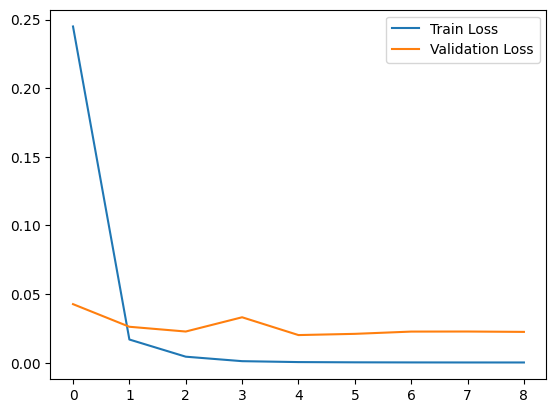

In [60]:
labels = pd.read_csv('drive/MyDrive/train.csv')
labels = labels.iloc[:, 1:].copy()
img_dir = 'drive/MyDrive/Images/train_data/'
model = ViTForImageClassification.from_pretrained('google/vit-base-patch16-224')
batch_size = 64
lr = 2e-5
img_size = (224, 224)
n_fold = 0
train_model(labels, img_dir, model, 'google/vit-base-patch16-224', img_size=img_size, num_epochs=10,
            batch_size=batch_size, lr=lr, n_fold=n_fold, patience=3, warmup_epochs=0)
torch.cuda.empty_cache()